# Import Dataset and Libraries

In [32]:
# Google Colab utilities
from google.colab import drive

# Standard library
import os
import random
import json

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Audio processing
import librosa
import librosa.display
import soundfile as sf

# Deep learning
from tensorflow import keras
from keras import layers, models
from keras import optimizers

# Machine learning utilities
from sklearn.model_selection import train_test_split

# Notebook-specific utilities
import IPython.display as ipd

# Dictionary utilities
from collections import defaultdict

In [2]:
!pip install soundfile --upgrade

In [3]:
!pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zahramohammadbeigi","key":"7f752472bd2b22cb188ddb50425c6da3"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mahdiahmadi81/noisy-audio-mnist

zip_file = "/content/noisy-audio-mnist.zip"
destination_dir = "/content/noisy-audio-mnist"

if not os.path.exists(zip_file):
    print(f"Error: {zip_file} not found.")
else:
    !unzip -q $zip_file -d $destination_dir
    !rm $zip_file

Dataset URL: https://www.kaggle.com/datasets/mahdiahmadi81/noisy-audio-mnist
License(s): CC0-1.0
100% 2.20G/2.21G [00:20<00:00, 172MB/s]
100% 2.21G/2.21G [00:20<00:00, 113MB/s]


In [5]:
# Load metadata
metadata = []
metadata_file = "/content/noisy-audio-mnist/audioMNIST_meta.txt"

try:
    with open(metadata_file, 'r') as file:
        metadata = json.load(file)

    metadata_df = pd.DataFrame(metadata).T
    print("Metadata Loaded Successfully:")
    print(metadata_df.head())
except Exception as e:
    print(f"Error loading metadata file: {e}")

Metadata Loaded Successfully:
    accent age gender native speaker                      origin  \
01  german  30   male             no  Europe, Germany, Wuerzburg   
02  German  25   male             no    Europe, Germany, Hamburg   
03  German  31   male             no     Europe, Germany, Bremen   
04  German  23   male             no  Europe, Germany, Helmstedt   
05  German  25   male             no     Europe, Germany, Hameln   

        recordingdate recordingroom  
01  17-06-22-11-04-28          Kino  
02  17-06-26-17-57-29          Kino  
03  17-06-30-17-34-51          Kino  
04  17-06-30-18-09-14          Kino  
05  17-07-06-10-53-10          Kino  


In [6]:
print("Summary of Speakers Metadata:")
print(metadata_df.describe(include="all"))

Summary of Speakers Metadata:
        accent age gender native speaker                   origin  \
count       60  60     60             60                       60   
unique      17  19      2              2                       42   
top     German  26   male             no  Europe, Germany, Berlin   
freq        40  10     48             57                       15   

            recordingdate recordingroom  
count                  60            60  
unique                 60             7  
top     17-06-22-11-04-28       vr-room  
freq                    1            28  


In [7]:
print(metadata_df.columns)

Index(['accent', 'age', 'gender', 'native speaker', 'origin', 'recordingdate',
       'recordingroom'],
      dtype='object')


In [8]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 01 to 60
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   accent          60 non-null     object
 1   age             60 non-null     object
 2   gender          60 non-null     object
 3   native speaker  60 non-null     object
 4   origin          60 non-null     object
 5   recordingdate   60 non-null     object
 6   recordingroom   60 non-null     object
dtypes: object(7)
memory usage: 3.8+ KB


In [9]:
print(metadata_df.isnull().sum())

accent            0
age               0
gender            0
native speaker    0
origin            0
recordingdate     0
recordingroom     0
dtype: int64


In [10]:
metadata_df['accent'].unique()

array(['german', 'German', 'German/Spanish', 'South Korean', 'Spanish',
       'Madras', 'Levant', 'English', 'Chinese', 'Brasilian', 'Italian',
       'Egyptian_American?', 'South African', 'Arabic', 'Danish',
       'French', 'Tamil'], dtype=object)

In [11]:
standardize_accent = {
    'german': 'German',
    'Egyptian_American?': 'Egyptian American'

}
metadata_df['accent'] = metadata_df['accent'].replace(standardize_accent)

In [12]:
# Convert metadata DataFrame to a dictionary
metadata_dict = metadata_df.to_dict(orient="index")

# Print the total number of entries and a sample for verification
print(f"Total speakers in metadata: {len(metadata_dict)}")
print(f"Sample entry for speaker '01': {metadata_dict['01']}")

Total speakers in metadata: 60
Sample entry for speaker '01': {'accent': 'German', 'age': 30, 'gender': 'male', 'native speaker': 'no', 'origin': 'Europe, Germany, Wuerzburg', 'recordingdate': '17-06-22-11-04-28', 'recordingroom': 'Kino'}


# Data Preparation and Analysis

In [13]:
base_dir = "/content/noisy-audio-mnist"

# Function to pair audio files with speaker index and spoken digit
def pair_audio_files_with_details(base_dir):
    audio_pairs = []

    for speaker in os.listdir(base_dir):
        speaker_path = os.path.join(base_dir, speaker)

        if not os.path.isdir(speaker_path) or not speaker.isdigit():
            continue

        all_files = [f for f in os.listdir(speaker_path) if f.endswith(".wav")]

        for file in all_files:
            if "_noisy" not in file:
                clean_path = os.path.join(speaker_path, file)
                noisy_file = file.replace(".wav", "_noisy.wav")
                noisy_path = os.path.join(speaker_path, noisy_file)

                if os.path.exists(noisy_path):
                    digit = int(file.split('_')[0])
                    audio_pairs.append({
                        "clean": clean_path,
                        "noisy": noisy_path,
                        "speaker_index": int(speaker),
                        "digit": digit
                    })

    return audio_pairs

audio_pairs = pair_audio_files_with_details(base_dir)
print(f"Total paired audio files: {len(audio_pairs)}")

Total paired audio files: 30000


In [14]:
audio_pairs[0]

{'clean': '/content/noisy-audio-mnist/47/2_47_46.wav',
 'noisy': '/content/noisy-audio-mnist/47/2_47_46_noisy.wav',
 'speaker_index': 47,
 'digit': 2}

## Getting Insights:

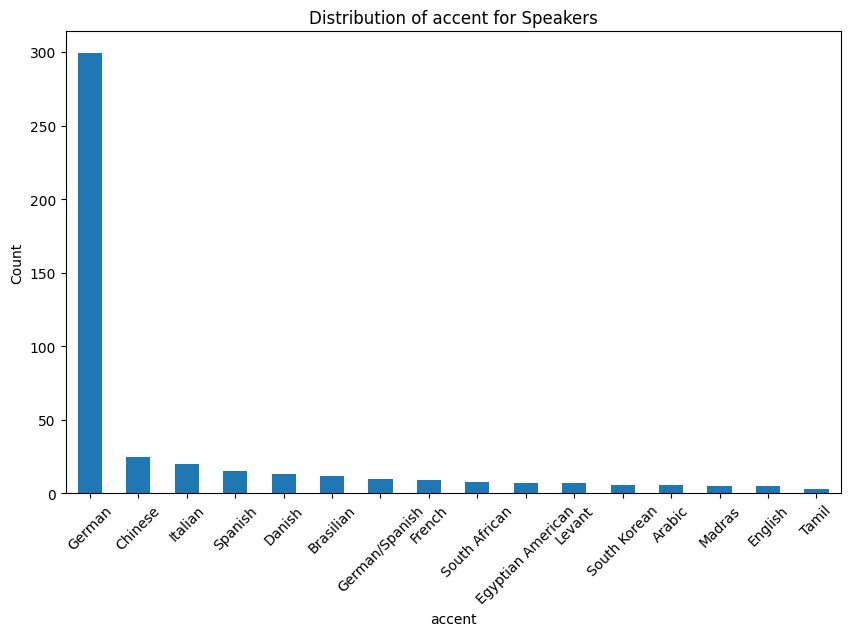

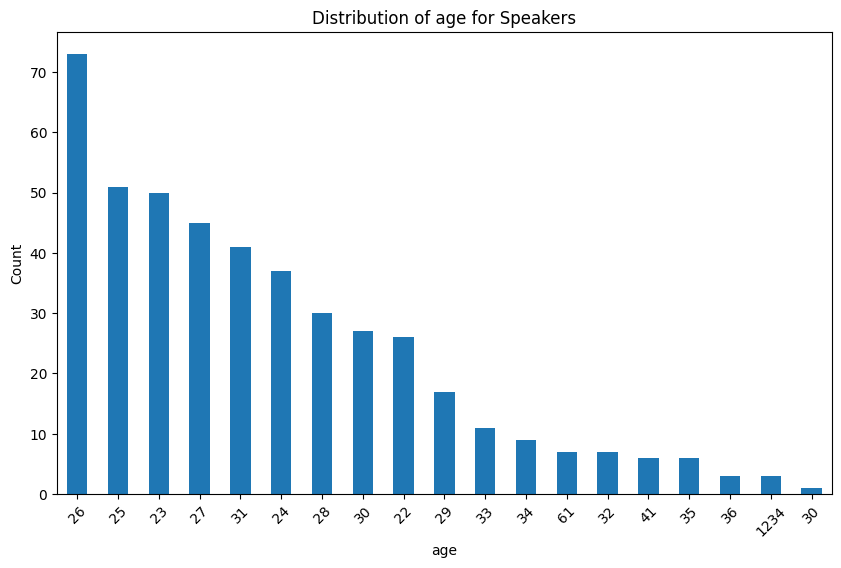

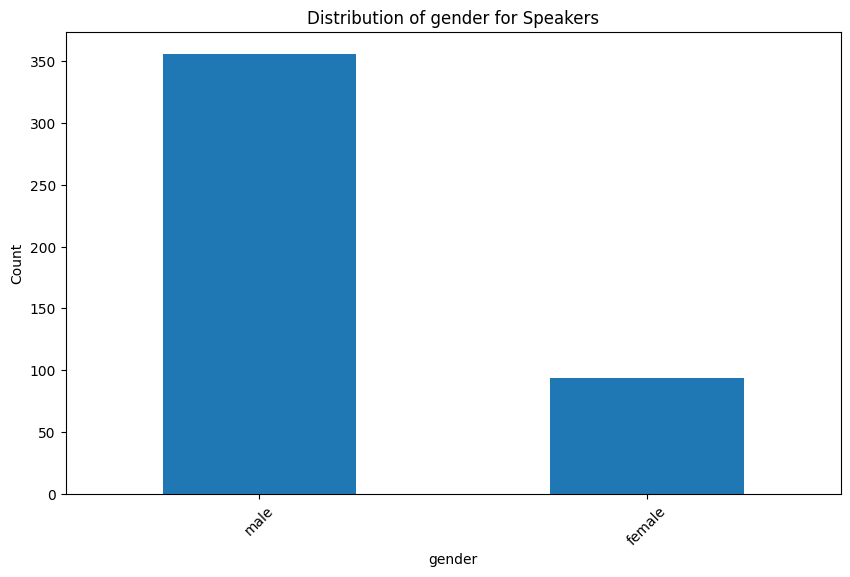

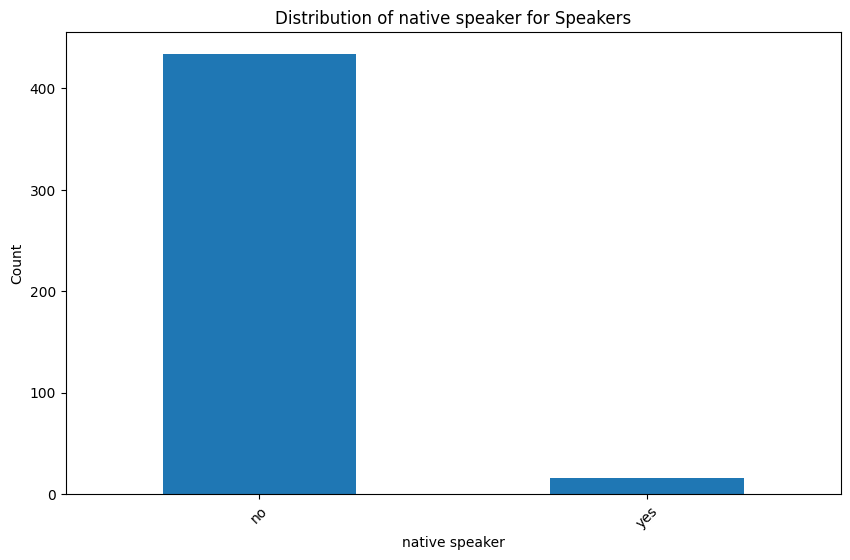

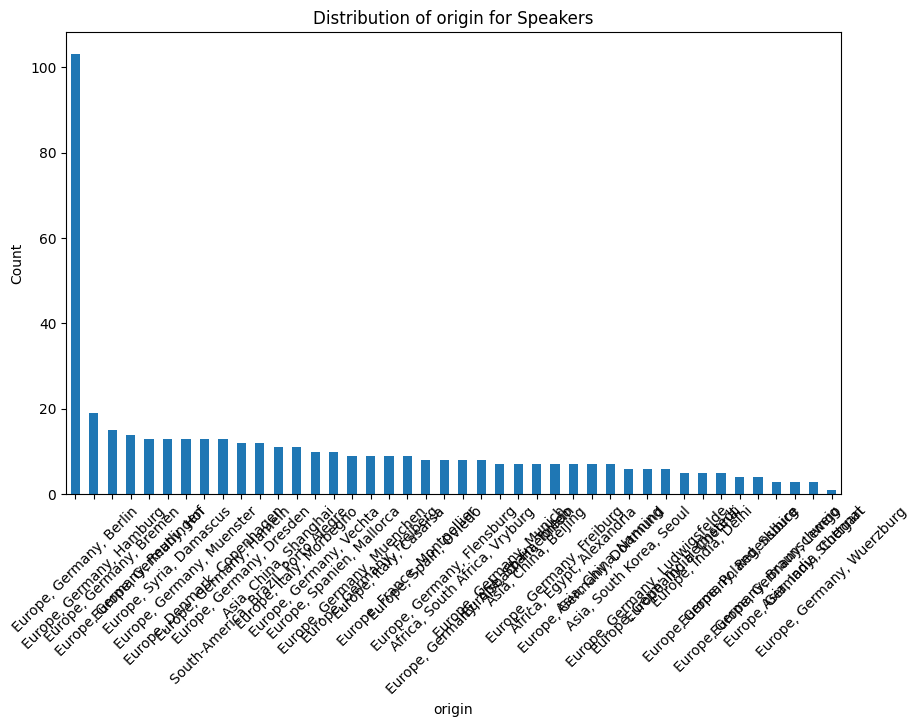

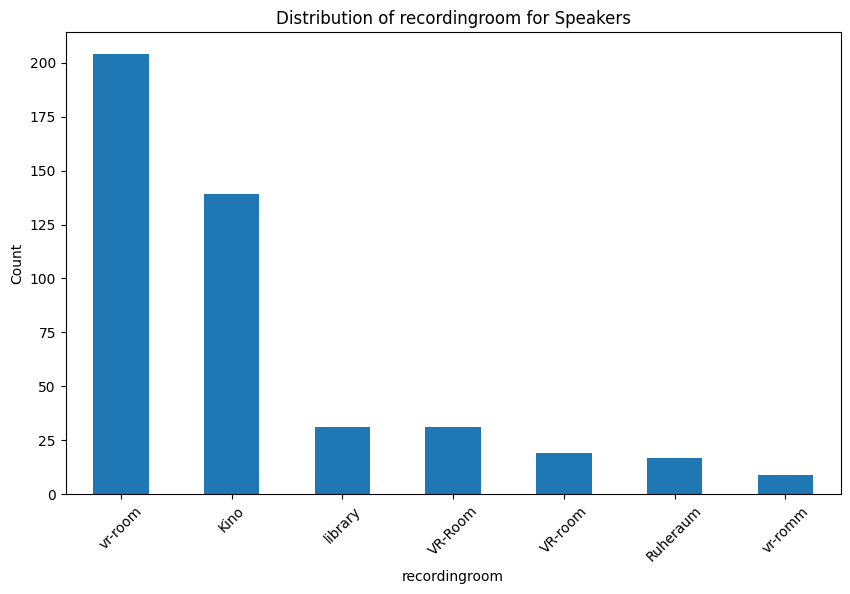

In [ ]:
# Visualizing the speaker attribute distributions
speaker_attributes = ['accent', 'age', 'gender', 'native speaker', 'origin', 'recordingroom']

for attr in speaker_attributes:
    plt.figure(figsize=(10, 6))
    metadata_attr = test_df['speaker_index'].map(lambda x: metadata_dict[str(x).zfill(2)].get(attr, 'Unknown'))
    metadata_attr.value_counts().plot(kind='bar')
    plt.title(f"Distribution of {attr} for Speakers")
    plt.xlabel(attr)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Load the first file in the dataset:
data_clean, sample_rate_clean = librosa.load(audio_pairs[0]['clean'], sr = None)
data_noisy, sample_rate_noisy = librosa.load(audio_pairs[0]['noisy'], sr = None)

# Embed for playback:
print('First clean audio:')
print('Duration:', len(data_clean)/sample_rate_clean, 's')
print(f"Spoken digit: {audio_pairs[0]['digit']}")
print(f"Speaker index: {audio_pairs[0]['speaker_index']}")
ipd.Audio(audio_pairs[0]['clean'])

First clean audio:
Duration: 0.6410208333333334 s
Spoken digit: 2
Speaker index: 47


In [ ]:
print('First noisy audio:')
ipd.Audio(audio_pairs[0]['noisy'])

First noisy audio:


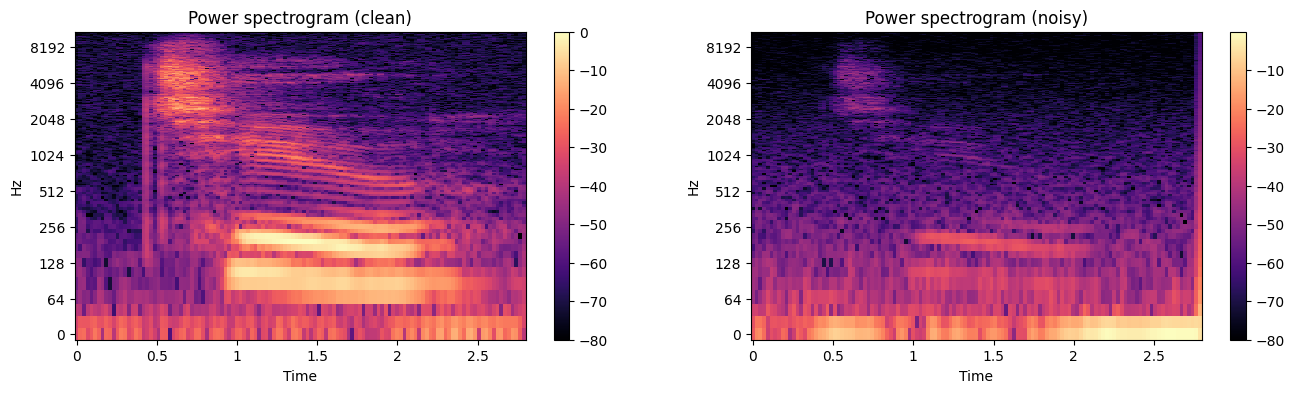

In [ ]:
# Calculate STFT to construct spectrogram:
S_noisy = np.abs(librosa.stft(data_noisy, n_fft=1024))
S = np.abs(librosa.stft(data_clean, n_fft=1024))

# Prepare plot:
fig, ax = plt.subplots(ncols=2, figsize = (16,4))
# Clean power spectrogram:
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax[0])
ax[0].set_title('Power spectrogram (clean)')
fig.colorbar(img, ax=ax[0])
# Noisy power spectrogram
img = librosa.display.specshow(librosa.amplitude_to_db(S_noisy, ref=np.max), y_axis='log', x_axis='time', ax=ax[1])
ax[1].set_title('Power spectrogram (noisy)')
fig.colorbar(img, ax=ax[1])

plt.show()

In [ ]:
def calculate_snr(clean_path, noisy_path):
    """
    Calculate SNR for a pair of clean and noisy audio files.

    Parameters:
        clean_path: Path to the clean audio file.
        noisy_path: Path to the noisy audio file.

    Returns:
        snr: Signal-to-Noise Ratio in decibels (dB).
    """
    try:
        # Load clean and noisy audio files
        clean_audio, _ = librosa.load(clean_path, sr=None)  # Use original sampling rate
        noisy_audio, _ = librosa.load(noisy_path, sr=None)

        # Ensure they are of the same length
        min_len = min(len(clean_audio), len(noisy_audio))
        clean_audio = clean_audio[:min_len]
        noisy_audio = noisy_audio[:min_len]

        # Calculate signal power and noise power
        signal_power = np.mean(clean_audio**2)
        noise_power = np.mean((noisy_audio - clean_audio)**2)

        # Avoid division by zero
        if noise_power == 0:
            return float('inf')  # Perfect signal

        # Compute SNR in dB
        snr = 10 * np.log10(signal_power / noise_power)
        return snr
    except Exception as e:
        print(f"Error processing files {clean_path} and {noisy_path}: {e}")
        return None

# Calculate SNRs for the first 1000 pairs
snr_values = []
for pair in audio_pairs:
    clean_path = pair['clean']
    noisy_path = pair['noisy']
    snr = calculate_snr(clean_path, noisy_path)
    if snr is not None:
        snr_values.append(snr)

# Analyze SNR values
print(f"Computed SNR for {len(snr_values)} audio pairs")
print(f"Mean SNR: {np.mean(snr_values):.2f} dB")
print(f"Min SNR: {np.min(snr_values):.2f} dB")
print(f"Max SNR: {np.max(snr_values):.2f} dB")

Computed SNR for 30000 audio pairs
Mean SNR: -24.46 dB
Min SNR: -46.93 dB
Max SNR: 7.57 dB


In [ ]:
def analyze_snr(audio_pairs, metadata_dict):
    # Initialize storage for SNR statistics
    digit_snr = defaultdict(list)
    accent_snr = defaultdict(list)

    # Compute SNR for each audio pair
    for pair in audio_pairs:
        clean_path = pair['clean']
        noisy_path = pair['noisy']
        digit = pair['digit']
        speaker_id = pair['speaker_index']
        speaker_id_str = f"{speaker_id:02d}"


        # Calculate SNR
        snr = calculate_snr(clean_path, noisy_path)
        if snr is not None:
            # Group SNR by digit
            digit_snr[digit].append(snr)

            # Group SNR by accent
            accent = metadata_dict[speaker_id_str]['accent']
            accent_snr[accent].append(snr)

    # Compute statistics for digits
    digit_stats = {digit: {
        'mean_snr': np.mean(snrs),
        'min_snr': np.min(snrs),
        'max_snr': np.max(snrs),
        'count': len(snrs)
    } for digit, snrs in digit_snr.items()}

    # Compute statistics for accents
    accent_stats = {accent: {
        'mean_snr': np.mean(snrs),
        'min_snr': np.min(snrs),
        'max_snr': np.max(snrs),
        'count': len(snrs)
    } for accent, snrs in accent_snr.items()}

    return digit_stats, accent_stats

# Example usage
digit_stats, accent_stats = analyze_snr(audio_pairs, metadata_dict)

# Print SNR statistics for digits
print("SNR Statistics by Digit:")
for digit, stats in sorted(digit_stats.items()):
    print(f"Digit {digit}: Mean SNR = {stats['mean_snr']:.2f}, "
          f"Min SNR = {stats['min_snr']:.2f}, Max SNR = {stats['max_snr']:.2f}, Count = {stats['count']}")

# Print SNR statistics for accents
print("\nSNR Statistics by Accent:")
for accent, stats in sorted(accent_stats.items()):
    print(f"Accent {accent}: Mean SNR = {stats['mean_snr']:.2f}, "
          f"Min SNR = {stats['min_snr']:.2f}, Max SNR = {stats['max_snr']:.2f}, Count = {stats['count']}")


SNR Statistics by Digit:
Digit 0: Mean SNR = -23.69, Min SNR = -39.69, Max SNR = 0.77, Count = 3000
Digit 1: Mean SNR = -23.55, Min SNR = -40.28, Max SNR = 1.24, Count = 3000
Digit 2: Mean SNR = -23.96, Min SNR = -42.21, Max SNR = 7.22, Count = 3000
Digit 3: Mean SNR = -24.15, Min SNR = -43.66, Max SNR = 4.44, Count = 3000
Digit 4: Mean SNR = -23.41, Min SNR = -42.14, Max SNR = 7.43, Count = 3000
Digit 5: Mean SNR = -24.24, Min SNR = -46.33, Max SNR = 7.57, Count = 3000
Digit 6: Mean SNR = -27.71, Min SNR = -46.93, Max SNR = 1.27, Count = 3000
Digit 7: Mean SNR = -24.95, Min SNR = -40.89, Max SNR = 5.80, Count = 3000
Digit 8: Mean SNR = -24.79, Min SNR = -41.84, Max SNR = 6.73, Count = 3000
Digit 9: Mean SNR = -24.17, Min SNR = -40.84, Max SNR = 3.71, Count = 3000

SNR Statistics by Accent:
Accent Arabic: Mean SNR = -21.61, Min SNR = -32.51, Max SNR = -4.78, Count = 500
Accent Brasilian: Mean SNR = -26.62, Min SNR = -34.88, Max SNR = -13.65, Count = 500
Accent Chinese: Mean SNR = -25.9

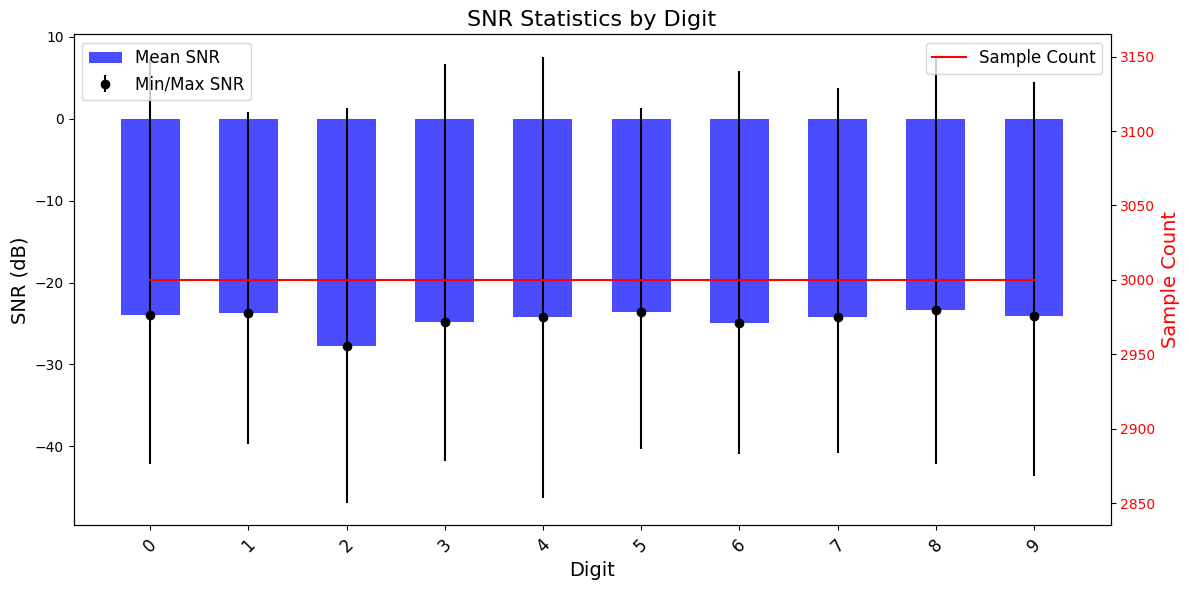

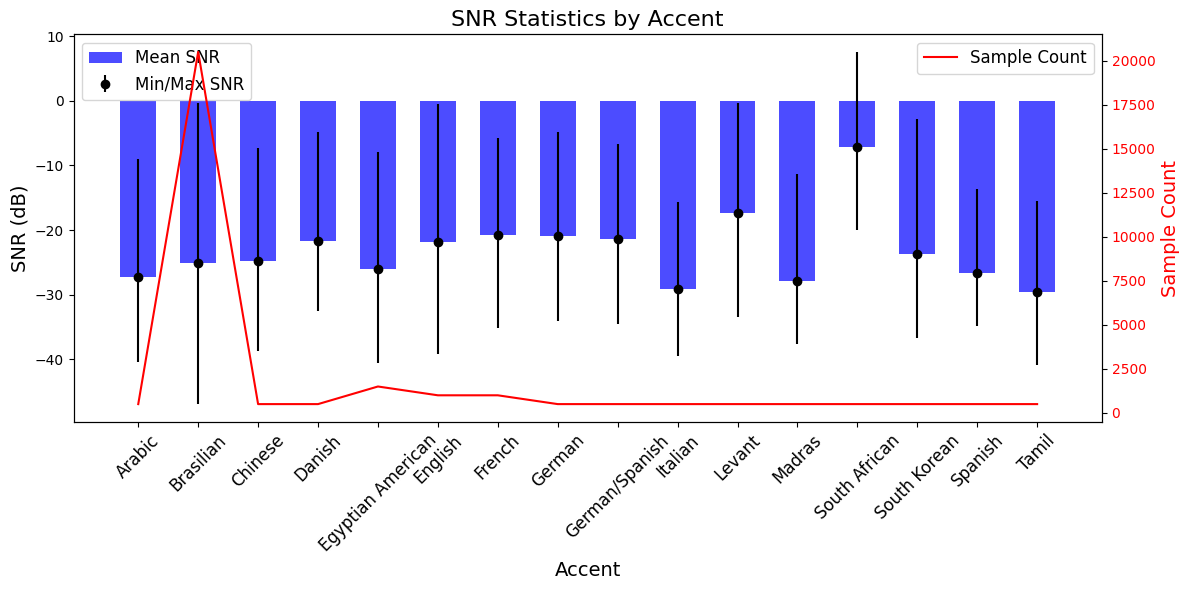

In [ ]:
def plot_snr_statistics(stats, title, xlabel, ylabel, category_labels):
    """
    Plot SNR statistics (mean, min, max) as bar charts.

    Parameters:
        stats: Dictionary containing mean, min, max, and count for each category.
        title: Title of the plot.
        xlabel: Label for the x-axis.
        ylabel: Label for the y-axis.
        category_labels: Labels for the categories (e.g., digits or accents).
    """
    categories = list(stats.keys())
    mean_snr = [stats[cat]['mean_snr'] for cat in categories]
    min_snr = [stats[cat]['min_snr'] for cat in categories]
    max_snr = [stats[cat]['max_snr'] for cat in categories]
    counts = [stats[cat]['count'] for cat in categories]

    x = range(len(categories))

    # Create a figure with two subplots
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot mean, min, max SNR
    ax1.bar(x, mean_snr, width=0.6, label='Mean SNR', alpha=0.7, color='blue')
    ax1.errorbar(x, mean_snr, yerr=[np.subtract(mean_snr, min_snr), np.subtract(max_snr, mean_snr)],
                 fmt='o', color='black', label='Min/Max SNR')

    ax1.set_xlabel(xlabel, fontsize=14)
    ax1.set_ylabel(ylabel, fontsize=14)
    ax1.set_title(title, fontsize=16)
    ax1.set_xticks(x)
    ax1.set_xticklabels(category_labels, rotation=45, fontsize=12)
    ax1.legend(loc='upper left', fontsize=12)

    # Add counts as a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(x, counts, 'r-', label='Sample Count')
    ax2.set_ylabel('Sample Count', fontsize=14, color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()

# Plot SNR statistics by digit
plot_snr_statistics(
    digit_stats,
    title="SNR Statistics by Digit",
    xlabel="Digit",
    ylabel="SNR (dB)",
    category_labels=[str(digit) for digit in sorted(digit_stats.keys())]
)

# Plot SNR statistics by accent
plot_snr_statistics(
    accent_stats,
    title="SNR Statistics by Accent",
    xlabel="Accent",
    ylabel="SNR (dB)",
    category_labels=[accent for accent in sorted(accent_stats.keys())]
)


# Feature Extraction

In [15]:
def get_spectrogram_features(audio_pairs, sample_rate=22050, duration_s=1):
    '''
    Function to generate features for audio de-noising:
    - Pads/crops audio to a fixed length.
    - Generates spectrograms of clean and noisy audios.
    - Outputs clean and noisy spectrogram features.
    '''

    X_clean = []
    X_noisy = []

    # Get duration in samples:
    duration = int(sample_rate * duration_s)

    for pair in audio_pairs:
        clean_path = pair['clean']
        noisy_path = pair['noisy']

        # Load clean and noisy audio
        try:
            data_clean, _ = librosa.load(clean_path, sr=sample_rate)
            data_noisy, _ = librosa.load(noisy_path, sr=sample_rate)
        except Exception as e:
            print(f"Error loading {clean_path} or {noisy_path}: {e}")
            continue

        # Pad/Cut to appropriate length to match the duration:
        if len(data_clean) < duration:
            # Padding for clean and noisy to the same length
            pad_len = duration - len(data_clean)
            pad_start = np.random.randint(0, pad_len // 2)
            pad_end = pad_len - pad_start
            data_clean = np.pad(data_clean, (pad_start, pad_end), "constant")
            data_noisy = np.pad(data_noisy, (pad_start, pad_end), "constant")

        elif len(data_clean) > duration:
            # Cropping clean and noisy to the same length
            crop_start = np.random.randint(0, len(data_clean) - duration)
            data_clean = data_clean[crop_start:crop_start + duration]
            data_noisy = data_noisy[crop_start:crop_start + duration]
        else:
            offset = 0

        S = np.abs(librosa.stft(data_clean, n_fft=2048))[:-1,:] # Hacky fix to keep the size reconstructable
        # Noisy spectrogram:
        S_noisy = np.abs(librosa.stft(data_noisy, n_fft=2048))[:-1,:] # Hacky fix to keep the size reconstructable

        # Append to feature lists
        X_clean.append(S)
        X_noisy.append(S_noisy)


    #  Convert lists to numpy ndarrays and expand dimensions:
    X_clean = np.array(X_clean)
    X_clean = np.expand_dims(X_clean, -1)

    X_noisy = np.array(X_noisy)
    X_noisy = np.expand_dims(X_noisy, -1)

    return X_clean, X_noisy

# Data Augmentation

In [16]:
def add_noise_to_audio(audio, noise_type='gaussian', snr_db=-20):
    """
    Adds noise (Gaussian or Pink) to the given audio signal.
    The noise is scaled according to the specified SNR (in dB).

    """
    # Ensure the noise matches the length of the audio
    audio_length = len(audio)

    if noise_type == 'gaussian':
        # Generate Gaussian noise with zero mean and unit variance, match audio length
        noise = np.random.normal(0, 1, audio_length)

    elif noise_type == 'pink':
        # Generate pink noise (this is a simple placeholder for pink noise)
        noise = np.random.randn(audio_length)
        # Optionally apply a filter to make it "pink"

    # Calculate the signal power and noise power
    signal_power = np.mean(audio ** 2)
    noise_power = signal_power / (10 ** (snr_db / 10))

    # Scale the noise to achieve the desired SNR
    scaling_factor = np.sqrt(noise_power / np.mean(noise ** 2))

    noisy_audio = audio + scaling_factor * noise
    return noisy_audio

In [17]:
def augment_data_with_noise(audio_pairs, noise_types=['gaussian', 'pink'], snr_range=(-30, -10), sample_rate=22050, save_dir='/content/noisy_audio_files'):
    """
    Augments the dataset by adding different types of noise at various SNR levels.

    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    augmented_audio_pairs = []

    for pair in audio_pairs:
        clean_path = pair['clean']
        noisy_path = pair['noisy']
        digit = pair['digit']
        speaker_id = pair['speaker_index']
        speaker_id_str = f"{speaker_id:02d}"

        try:
            clean_audio, _ = librosa.load(clean_path, sr=sample_rate)
        except Exception as e:
            print(f"Error loading file {clean_path}: {e}")
            continue

        augmented_audio_pairs.append({
            'clean': clean_path,
            'noisy': noisy_path,
            'speaker_index': pair['speaker_index'],
            'digit': digit,
            'noise_type': 'original',
            'snr_db': None
        })

        # Augment the clean audio with different types of noise
        for noise_type in noise_types:
          snr_db = random.uniform(snr_range[0], snr_range[1])
          # Generate noisy audio using the add_noise_to_audio function
          noisy_audio = add_noise_to_audio(clean_audio, noise_type=noise_type, snr_db=snr_db)

          # Create a filename for the noisy audio
          noisy_filename = f"{os.path.splitext(os.path.basename(clean_path))[0]}_{noise_type}_{snr_db}dB.wav"
          noisy_filepath = os.path.join(save_dir, noisy_filename)

          # Save the noisy audio to a file
          sf.write(noisy_filepath, noisy_audio, sample_rate)

          augmented_audio_pairs.append({
              'clean': clean_path,
              'noisy': noisy_filepath,
              'speaker_index': pair['speaker_index'],
              'digit': pair['digit'],
              'noise_type': noise_type,
              'snr_db': snr_db
          })

    return augmented_audio_pairs

Due to constraints in storage space and memory, only 1000 samples will be used. As the first 1000 samples from the dataset would only correspond to two speakers, the filepaths list can be resampled to acquire a balanced training set.

In [18]:
# Shuffle filepaths:
random.shuffle(audio_pairs)

augmented_audio_pairs = augment_data_with_noise(audio_pairs[:1000], noise_types=['gaussian', 'pink'])

# Check the size of the augmented dataset
print(f"Original dataset size: {len(audio_pairs[:1000])}")
print(f"Augmented dataset size: {len(augmented_audio_pairs)}")

Original dataset size: 1000
Augmented dataset size: 3000


In [19]:
augmented_audio_pairs[0]

{'clean': '/content/noisy-audio-mnist/21/5_21_45.wav',
 'noisy': '/content/noisy-audio-mnist/21/5_21_45_noisy.wav',
 'speaker_index': 21,
 'digit': 5,
 'noise_type': 'original',
 'snr_db': None}

In [20]:
augmented_audio_pairs[1]

{'clean': '/content/noisy-audio-mnist/21/5_21_45.wav',
 'noisy': '/content/noisy_audio_files/5_21_45_gaussian_-15.129839384958803dB.wav',
 'speaker_index': 21,
 'digit': 5,
 'noise_type': 'gaussian',
 'snr_db': -15.129839384958803}

In [21]:
augmented_audio_pairs[2]

{'clean': '/content/noisy-audio-mnist/21/5_21_45.wav',
 'noisy': '/content/noisy_audio_files/5_21_45_pink_-15.022798442946495dB.wav',
 'speaker_index': 21,
 'digit': 5,
 'noise_type': 'pink',
 'snr_db': -15.022798442946495}

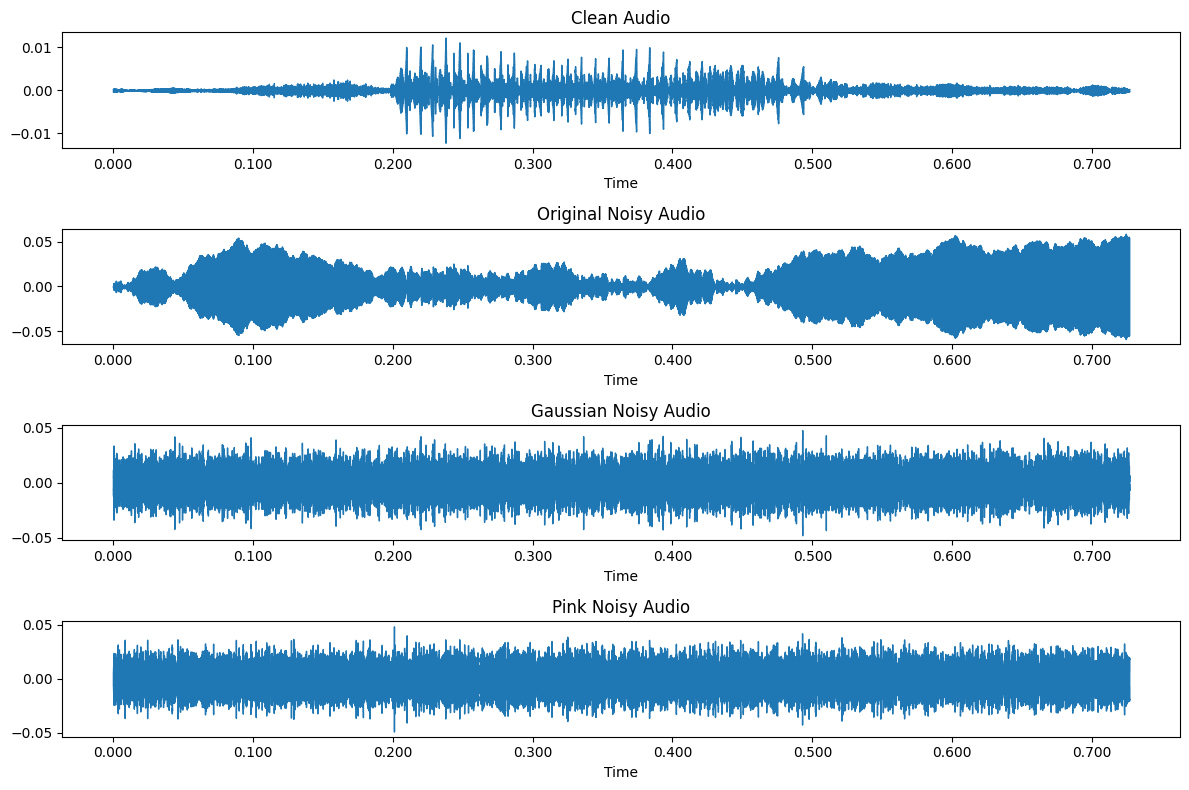

In [22]:
# Extract clean, original noisy, Gaussian noisy, and Pink noisy audio
clean_audio, sr = librosa.load(augmented_audio_pairs[0]['clean'], sr=None)
original_noisy_audio, _ = librosa.load(augmented_audio_pairs[0]['noisy'], sr=sr)
gaussian_noisy_audio, _ = librosa.load(augmented_audio_pairs[1]['noisy'], sr=sr)
pink_noisy_audio, _ = librosa.load(augmented_audio_pairs[2]['noisy'], sr=sr)

# Plot the waveforms
plt.figure(figsize=(12, 8))

# Clean audio waveform
plt.subplot(4, 1, 1)
librosa.display.waveshow(clean_audio, sr=sr)
plt.title('Clean Audio')

# Original noisy audio waveform
plt.subplot(4, 1, 2)
librosa.display.waveshow(original_noisy_audio, sr=sr)
plt.title('Original Noisy Audio')

# Gaussian noisy audio waveform
plt.subplot(4, 1, 3)
librosa.display.waveshow(gaussian_noisy_audio, sr=sr)
plt.title('Gaussian Noisy Audio')

# Pink noisy audio waveform
plt.subplot(4, 1, 4)
librosa.display.waveshow(pink_noisy_audio, sr=sr)
plt.title('Pink Noisy Audio')

plt.tight_layout()
plt.show()


<ipython-input-23-ecaecf0b52a3>:8: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  clean_spectrogram = librosa.amplitude_to_db(librosa.stft(clean_audio), ref=np.max)
<ipython-input-23-ecaecf0b52a3>:9: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  original_noisy_spectrogram = librosa.amplitude_to_db(librosa.stft(original_noisy_audio), ref=np.max)
<ipython-input-23-ecaecf0b52a3>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  gaussian_noisy_spectrogram = librosa.amplitude_to_db(librosa.stft(gaussian_noisy_audio), ref=np.max)
<ipython-input-23-ecaecf0b52a3>:11: UserWarning: amplitude_to_db was called on complex input so phase informati

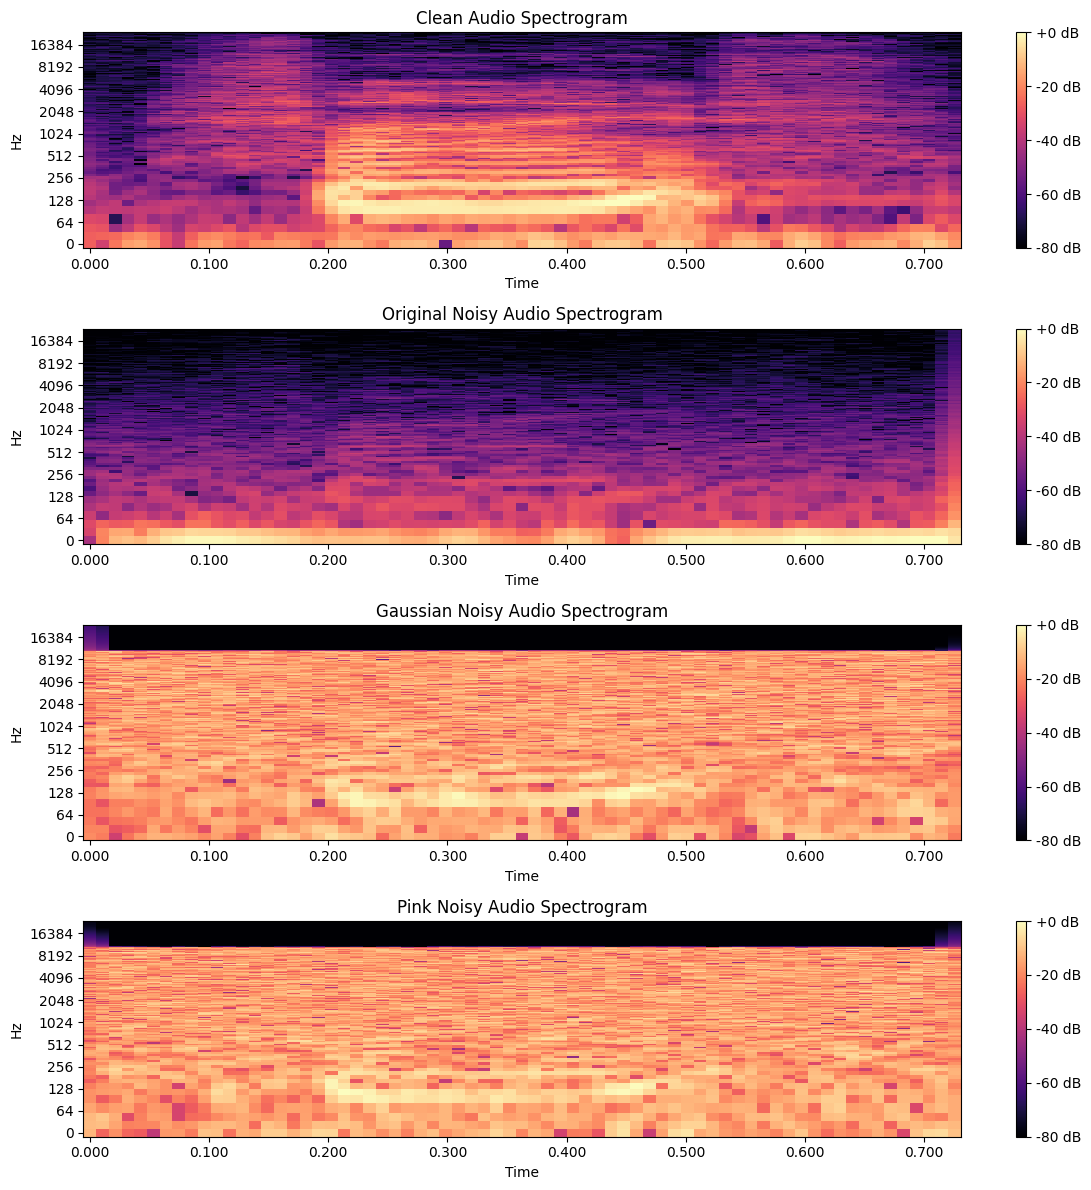

In [23]:
# Extract clean, original noisy, Gaussian noisy, and Pink noisy audio
clean_audio, sr = librosa.load(augmented_audio_pairs[0]['clean'], sr=None)
original_noisy_audio, _ = librosa.load(augmented_audio_pairs[0]['noisy'], sr=sr)
gaussian_noisy_audio, _ = librosa.load(augmented_audio_pairs[1]['noisy'], sr=sr)
pink_noisy_audio, _ = librosa.load(augmented_audio_pairs[2]['noisy'], sr=sr)

# Compute spectrograms
clean_spectrogram = librosa.amplitude_to_db(librosa.stft(clean_audio), ref=np.max)
original_noisy_spectrogram = librosa.amplitude_to_db(librosa.stft(original_noisy_audio), ref=np.max)
gaussian_noisy_spectrogram = librosa.amplitude_to_db(librosa.stft(gaussian_noisy_audio), ref=np.max)
pink_noisy_spectrogram = librosa.amplitude_to_db(librosa.stft(pink_noisy_audio), ref=np.max)

# Plot the spectrograms
plt.figure(figsize=(12, 12))

# Clean audio spectrogram
plt.subplot(4, 1, 1)
librosa.display.specshow(clean_spectrogram, x_axis='time', y_axis='log', sr=sr)
plt.title('Clean Audio Spectrogram')
plt.colorbar(format='%+2.0f dB')

# Original noisy audio spectrogram
plt.subplot(4, 1, 2)
librosa.display.specshow(original_noisy_spectrogram, x_axis='time', y_axis='log', sr=sr)
plt.title('Original Noisy Audio Spectrogram')
plt.colorbar(format='%+2.0f dB')

# Gaussian noisy audio spectrogram
plt.subplot(4, 1, 3)
librosa.display.specshow(gaussian_noisy_spectrogram, x_axis='time', y_axis='log', sr=sr)
plt.title('Gaussian Noisy Audio Spectrogram')
plt.colorbar(format='%+2.0f dB')

# Pink noisy audio spectrogram
plt.subplot(4, 1, 4)
librosa.display.specshow(pink_noisy_spectrogram, x_axis='time', y_axis='log', sr=sr)
plt.title('Pink Noisy Audio Spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [24]:
# Get spectrogram features:
X_clean, X_noisy = get_spectrogram_features(augmented_audio_pairs)
# Define input shape for the model:
spec_shape = (X_clean.shape[1], X_clean.shape[2])

In [25]:
spec_shape

(1024, 44)

# Model Implementation

In [28]:
# Split data into train (70%), validation (15%), and test (15%)
X_noisy_train, X_noisy_temp, X_clean_train, X_clean_temp = train_test_split(X_noisy, X_clean, test_size=0.3, random_state=42)
X_noisy_val, X_noisy_test, X_clean_val, X_clean_test = train_test_split(X_noisy_temp, X_clean_temp, test_size=0.5, random_state=42)

print(f"Training pairs: {len(X_noisy_train)}, Validation pairs: {len(X_noisy_val)}, Test pairs: {len(X_noisy_test)}")

Training pairs: 2100, Validation pairs: 450, Test pairs: 450


In [29]:
# Normalization
X_noisy_train = (X_noisy_train - X_noisy_train.mean()) / X_noisy_train.std()
X_noisy_val = (X_noisy_val - X_noisy_val.mean()) / X_noisy_val.std()
X_noisy_test = (X_noisy_test - X_noisy_test.mean()) / X_noisy_test.std()

X_clean_train = (X_clean_train - X_clean_train.mean()) / X_clean_train.std()
X_clean_val = (X_clean_val - X_clean_val.mean()) / X_clean_val.std()
X_clean_test = (X_clean_test - X_clean_test.mean()) / X_clean_test.std()

In [30]:
# Convolutional Autoencoder

encoder_input = layers.Input(shape=(spec_shape[0], spec_shape[1], 1), name='encoder_in')

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
encoder_output = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_output)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = models.Model(encoder_input, decoder_output)
autoencoder.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='mse')

In [31]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_in (InputLayer)              │ (None, 1024, 44, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 1024, 44, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1024, 44, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 1024, 44, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1024, 44, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 1024, 44, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1024, 44, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 512, 22, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 512, 22, 128)        │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 512, 22, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 1024, 44, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 1024, 44, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 1024, 44, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 1024, 44, 1)         │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 316,289 (1.21 MB)

 Trainable params: 315,457 (1.20 MB)

 Non-trainable params: 832 (3.25 KB)

In [33]:
# Callbacks
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
]

# Train the model
history = autoencoder.fit(
    X_noisy_train, X_clean_train,
    epochs=50,
    shuffle=True,
    validation_data=(X_noisy_val, X_clean_val),
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - loss: 1.0555 - val_loss: 1.0540 - learning_rate: 1.0000e-04
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 61s 494ms/step - loss: 1.0549 - val_loss: 1.0259 - learning_rate: 1.0000e-04
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 503ms/step - loss: 1.0674 - val_loss: 1.0244 - learning_rate: 1.0000e-04
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 489ms/step - loss: 0.9577 - val_loss: 1.0104 - learning_rate: 1.0000e-04
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 498ms/step - loss: 0.8807 - val_loss: 1.0187 - learning_rate: 1.0000e-04
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 505ms/step - loss: 0.9501 - val_loss: 1.1097 - learning_rate: 1.0000e-04
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 494ms/step - loss: 0.9845 - val_loss: 0.9882 - learning_rate: 1.0000e-04
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 496ms/step - loss: 0.9544 - val_loss: 0.9763 - learning_rate: 1.0000e-04
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 505ms/step - loss: 0.9552 - val_loss: 0.

In [34]:
def compute_snr(clean, denoised):
    """
    Compute Signal-to-Noise Ratio (SNR).
    """
    signal_power = np.mean(clean**2)
    noise_power = np.mean((clean - denoised)**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

X_denoised_test = autoencoder.predict(X_noisy_test)
snr_values = [compute_snr(clean, denoised) for clean, denoised in zip(X_clean_test, X_denoised_test)]

average_snr = np.mean(snr_values)
print(f"Average SNR Improvement on Test Data: {average_snr:.2f} dB")

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step
Average SNR Improvement on Test Data: 0.52 dB


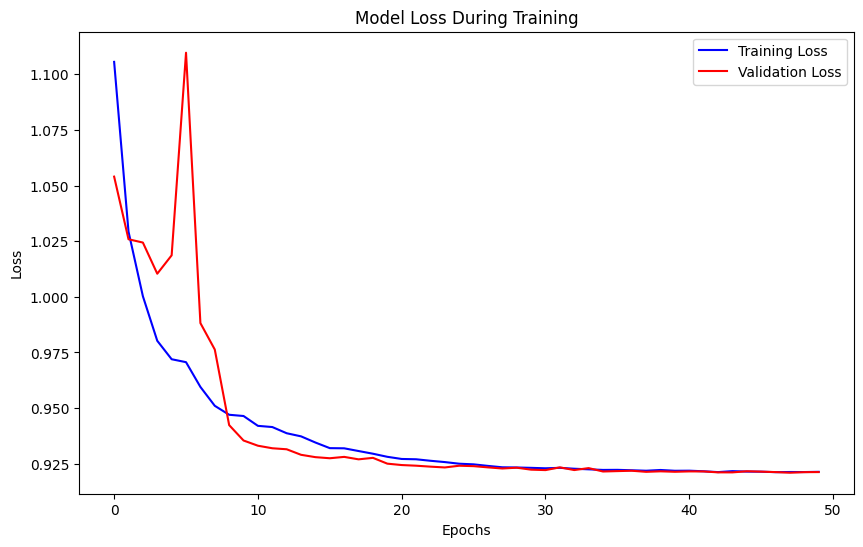

In [35]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Visualize and Listen to a Sample

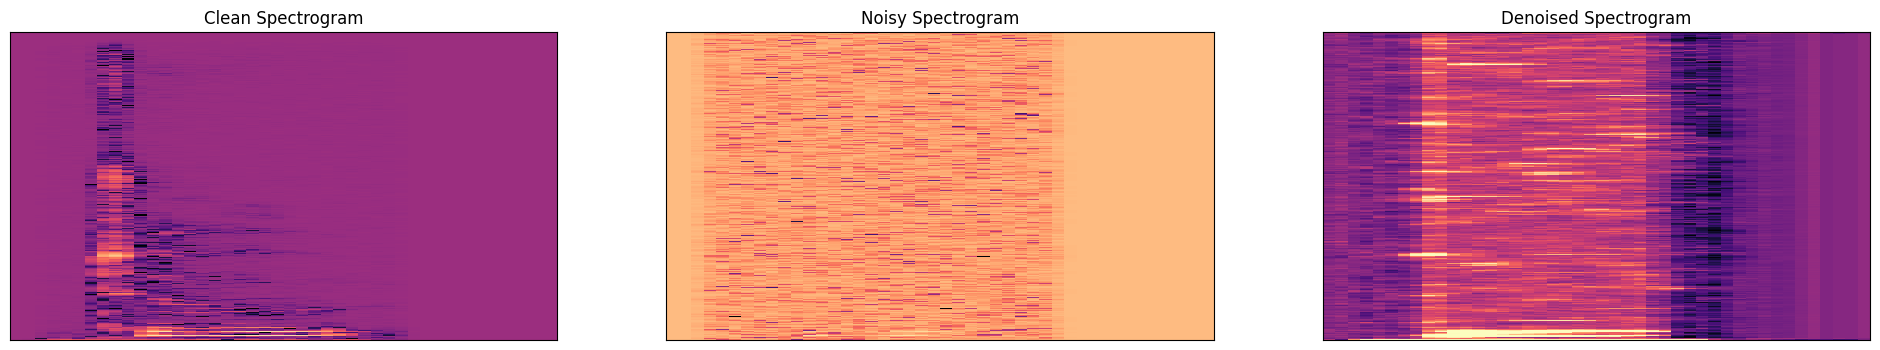

In [36]:
# Visualize a sample from test
def spec_plot(spectrogram, ax_index, title):
    spectrogram = spectrogram.reshape((1024, 44))
    librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref = np.max), ax = ax[ax_index])
    ax[ax_index].set_title(title)

# Index of sample to check:
index = 3

fig, ax = plt.subplots(ncols=3, figsize = (24,4))
clean = X_clean_test[index]
spec_plot(clean, 0, 'Clean Spectrogram')
noisy = X_noisy_test[index]
spec_plot(noisy, 1, 'Noisy Spectrogram')
denoised = X_denoised_test[index]
spec_plot(denoised, 2, 'Denoised Spectrogram')
plt.show()

In [37]:
# Function to convert spectrogram to waveform
def spectrogram_to_audio(spectrogram):
    spectrogram = spectrogram.reshape((1024, 44))
    return librosa.griffinlim(spectrogram)

clean_waveform = spectrogram_to_audio(clean)
noisy_waveform = spectrogram_to_audio(noisy)
denoised_waveform = spectrogram_to_audio(denoised)

print("Clean Audio:")
display(ipd.Audio(clean_waveform, rate=22050))

print("Noisy Audio:")
display(ipd.Audio(noisy_waveform, rate=22050))

print("Denoised Audio:")
display(ipd.Audio(denoised_waveform, rate=22050))

Clean Audio:


Noisy Audio:


Denoised Audio:


# Performance Comparison Across Different Speakers and Digits (Second Model)

In [38]:
# Add speaker and digit information to test samples
test_sample_info = [
    {
        "snr": snr,
        "speaker_index": augmented_audio_pairs[i]["speaker_index"],
        "digit": augmented_audio_pairs[i]["digit"]
    }
    for i, snr in enumerate(snr_values[:len(X_clean_test)])
]

# Add speaker metadata
for sample in test_sample_info:
    speaker_index = str(sample["speaker_index"]).zfill(2)
    sample.update(metadata_dict[speaker_index])

test_df = pd.DataFrame(test_sample_info)

# Average SNR by speaker
snr_by_speaker = test_df.groupby("speaker_index")["snr"].mean()

# Average SNR by digit
snr_by_digit = test_df.groupby("digit")["snr"].mean()

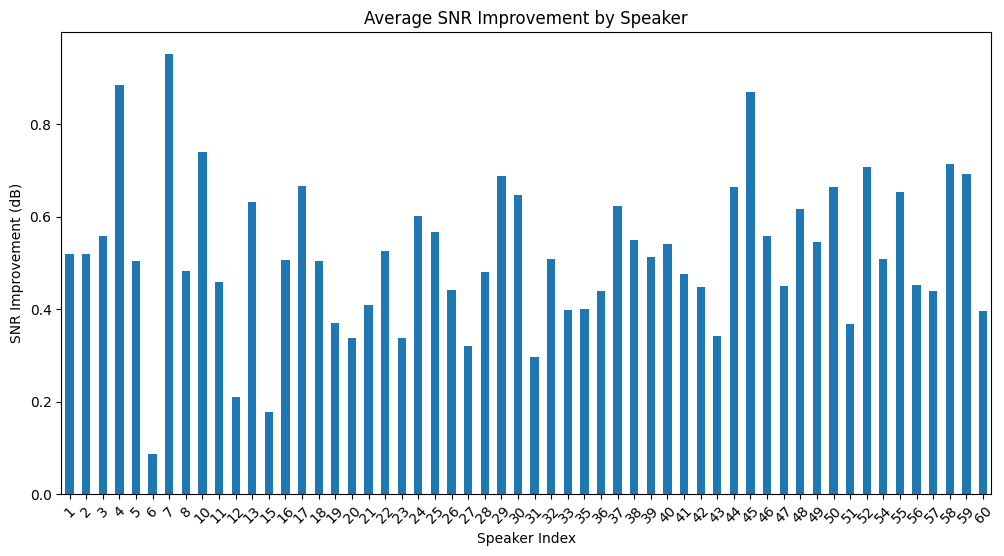

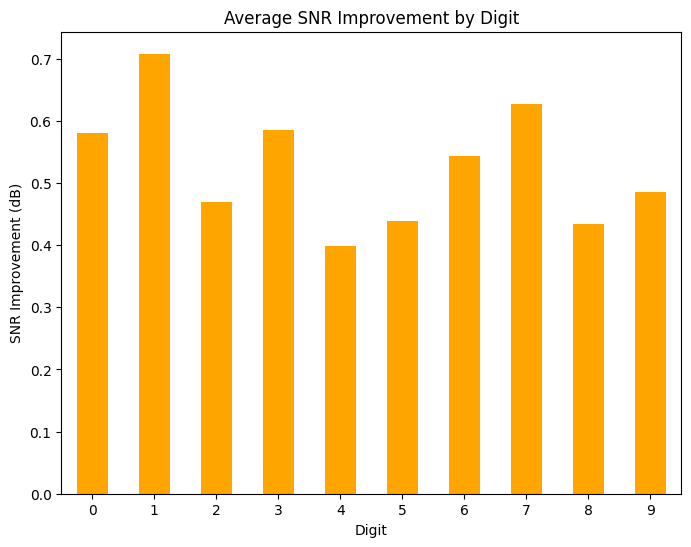

In [39]:
# Bar plot for speakers
plt.figure(figsize=(12, 6))
snr_by_speaker.sort_index().plot(kind="bar")
plt.title("Average SNR Improvement by Speaker")
plt.xlabel("Speaker Index")
plt.ylabel("SNR Improvement (dB)")
plt.xticks(rotation=45)
plt.show()

# Bar plot for digits
plt.figure(figsize=(8, 6))
snr_by_digit.sort_index().plot(kind="bar", color="orange")
plt.title("Average SNR Improvement by Digit")
plt.xlabel("Digit")
plt.ylabel("SNR Improvement (dB)")
plt.xticks(rotation=0)
plt.show()

In [40]:
snr_by_speaker

,snr
speaker_index,
1,0.519048
2,0.519042
3,0.559039
4,0.885792
5,0.503495
6,0.087490
7,0.951227
8,0.481853
10,0.740208


In [41]:
snr_by_digit

,snr
digit,
0,0.579921
1,0.707920
2,0.468829
3,0.585065
4,0.398502
5,0.438854
6,0.542865
7,0.626374
8,0.433680


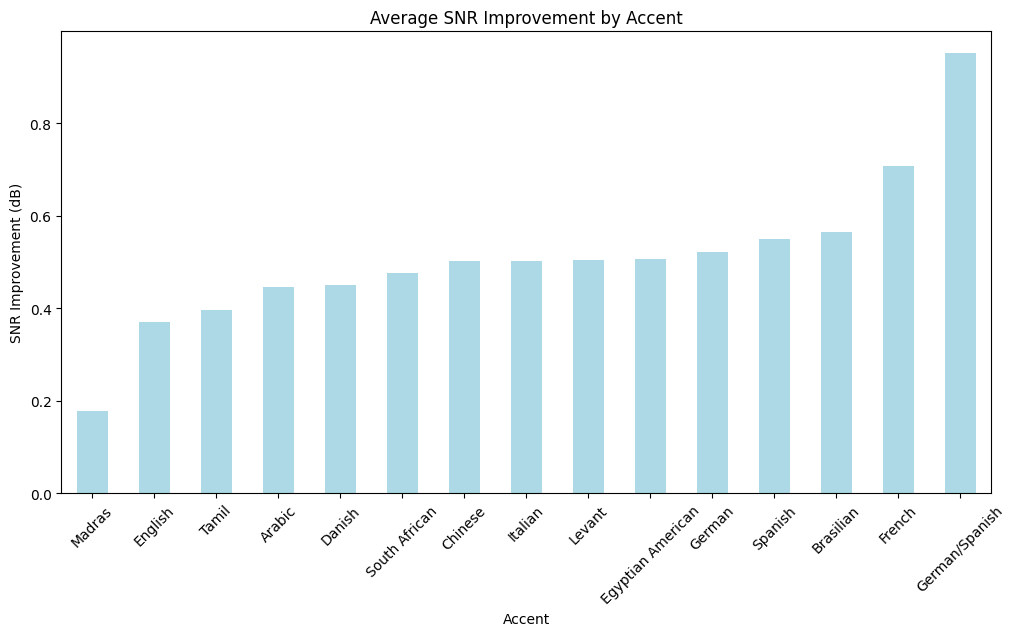

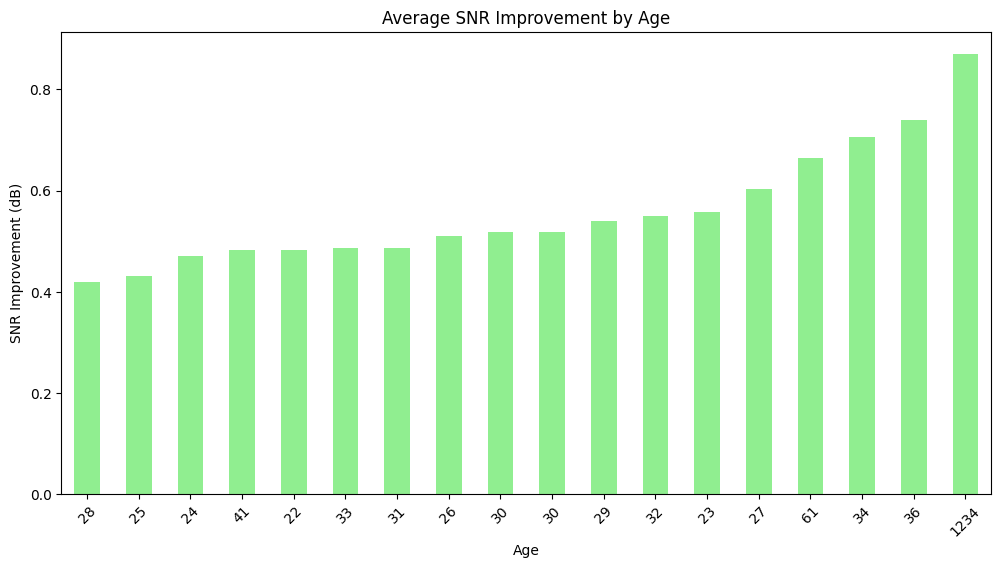

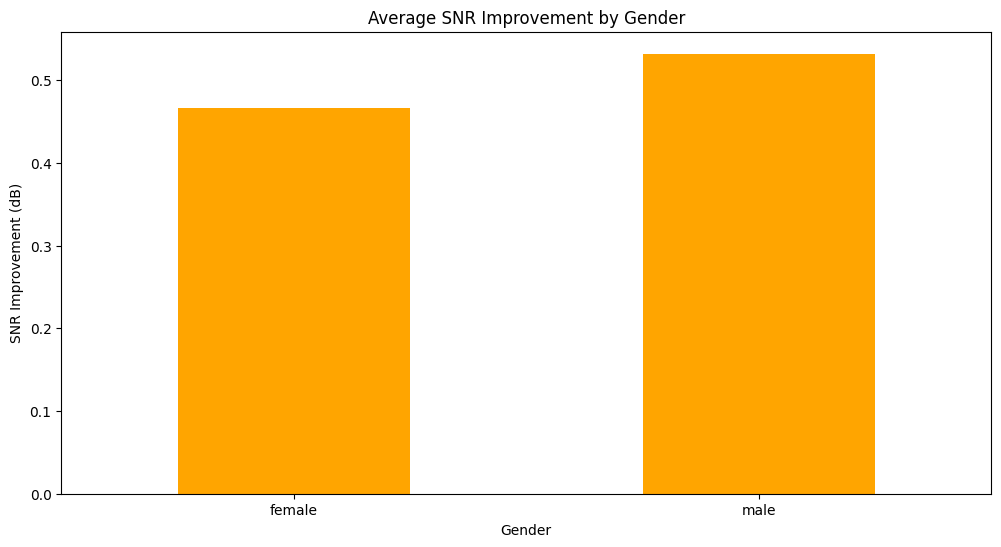

In [42]:
# SNR by Accent
snr_by_accent = test_df.groupby(test_df['speaker_index'].map(lambda x: metadata_dict[str(x).zfill(2)]['accent']))['snr'].mean()

# SNR by Age
snr_by_age = test_df.groupby(test_df['speaker_index'].map(lambda x: metadata_dict[str(x).zfill(2)]['age']))['snr'].mean()

# SNR by Gender
snr_by_gender = test_df.groupby(test_df['speaker_index'].map(lambda x: metadata_dict[str(x).zfill(2)]['gender']))['snr'].mean()

# Bar plot for accent
plt.figure(figsize=(12, 6))
snr_by_accent.sort_values().plot(kind="bar", color="lightblue")
plt.title("Average SNR Improvement by Accent")
plt.xlabel("Accent")
plt.ylabel("SNR Improvement (dB)")
plt.xticks(rotation=45)
plt.show()

# Bar plot for age
plt.figure(figsize=(12, 6))
snr_by_age.sort_values().plot(kind="bar", color="lightgreen")
plt.title("Average SNR Improvement by Age")
plt.xlabel("Age")
plt.ylabel("SNR Improvement (dB)")
plt.xticks(rotation=45)
plt.show()

# Bar plot for gender
plt.figure(figsize=(12, 6))
snr_by_gender.sort_values().plot(kind="bar", color="orange")
plt.title("Average SNR Improvement by Gender")
plt.xlabel("Gender")
plt.ylabel("SNR Improvement (dB)")
plt.xticks(rotation=0)
plt.show()

In [48]:
snr_by_accent_numeric = snr_by_accent.round(2).sort_values().to_dict()
print("SNR by Accent:")
print(snr_by_accent_numeric)

snr_by_age_numeric = snr_by_age.round(2).sort_values().to_dict()
print("\nSNR by Age:")
print(snr_by_age_numeric)

snr_by_gender_numeric = snr_by_gender.round(2).sort_values().to_dict()
print("\nSNR by Gender:")
print(snr_by_gender_numeric)

SNR by Accent:
{'Madras': 0.18, 'English': 0.37, 'Tamil': 0.4, 'Arabic': 0.45, 'Danish': 0.45, 'South African': 0.48, 'Italian': 0.5, 'Chinese': 0.5, 'Levant': 0.5, 'Egyptian American': 0.51, 'German': 0.52, 'Spanish': 0.55, 'Brasilian': 0.57, 'French': 0.71, 'German/Spanish': 0.95}

SNR by Age:
{'28': 0.42, '25': 0.43, '24': 0.47, '22': 0.48, '41': 0.48, '31': 0.49, '33': 0.49, '26': 0.51, '30': 0.52, 30: 0.52, '29': 0.54, '32': 0.55, '23': 0.56, '27': 0.6, '61': 0.66, '34': 0.71, '36': 0.74, '1234': 0.87}

SNR by Gender:
{'female': 0.47, 'male': 0.53}


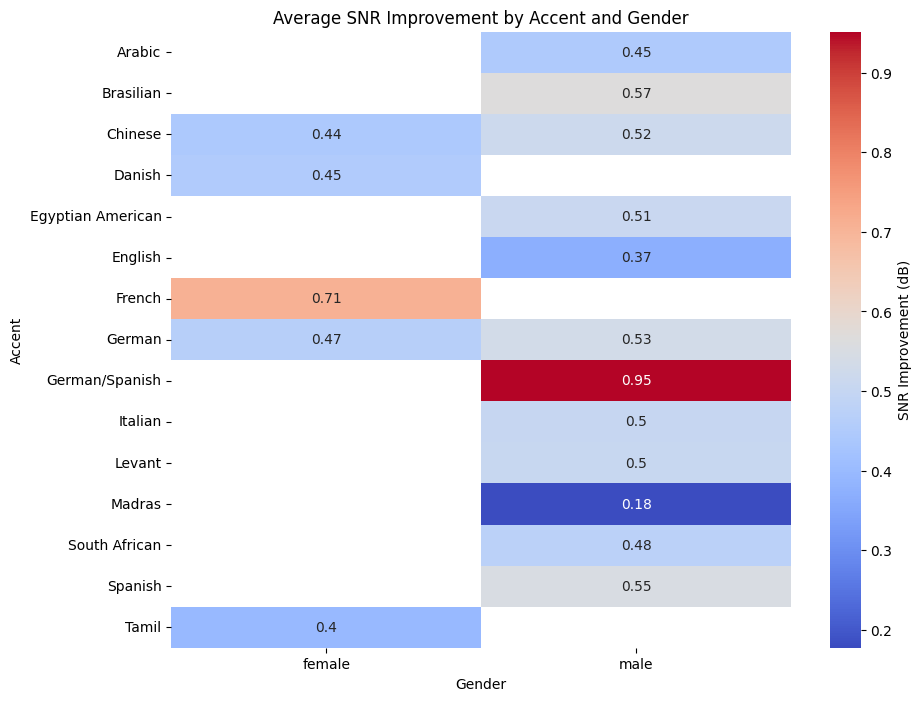

In [49]:
# Group by accent and gender
snr_by_accent_gender = test_df.groupby([test_df['speaker_index'].map(lambda x: metadata_dict[str(x).zfill(2)]['accent']),
                                         test_df['speaker_index'].map(lambda x: metadata_dict[str(x).zfill(2)]['gender'])])['snr'].mean()

# Heatmap of SNR by accent and gender
plt.figure(figsize=(10, 8))
snr_by_accent_gender = snr_by_accent_gender.unstack()
sns.heatmap(snr_by_accent_gender, annot=True, cmap='coolwarm', cbar_kws={'label': 'SNR Improvement (dB)'})
plt.title("Average SNR Improvement by Accent and Gender")
plt.xlabel("Gender")
plt.ylabel("Accent")
plt.show()

In [50]:
# Group by accent and gender and calculate mean SNR
snr_by_accent_gender = test_df.groupby([test_df['speaker_index'].map(lambda x: metadata_dict[str(x).zfill(2)]['accent']),
                                         test_df['speaker_index'].map(lambda x: metadata_dict[str(x).zfill(2)]['gender'])])['snr'].mean()

# Unstack the DataFrame to get a matrix of SNR by accent and gender
snr_by_accent_gender_matrix = snr_by_accent_gender.unstack()

# Print or return the numeric values (SNR values)
print(snr_by_accent_gender_matrix)

# Optionally, you can save the numeric values to a CSV or Excel file for reference
snr_by_accent_gender_matrix.to_csv('snr_by_accent_gender.csv')  # Save to CSV


speaker_index        female      male
speaker_index                        
Arabic                  NaN  0.447408
Brasilian               NaN  0.566332
Chinese            0.441534  0.517038
Danish             0.450470       NaN
Egyptian American       NaN  0.507961
English                 NaN  0.370422
French             0.706985       NaN
German             0.467371  0.532954
German/Spanish          NaN  0.951227
Italian                 NaN  0.502038
Levant                  NaN  0.504259
Madras                  NaN  0.177623
South African           NaN  0.476507
Spanish                 NaN  0.549739
Tamil              0.396411       NaN


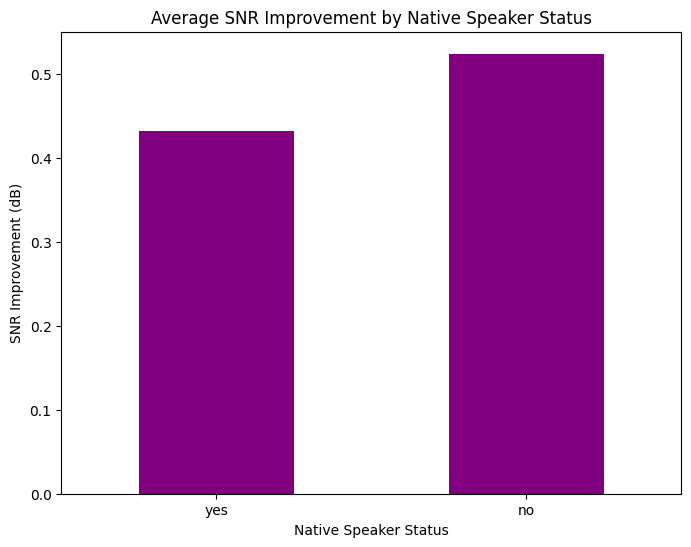

In [52]:
# SNR by native speaker status
snr_by_native_speaker = test_df.groupby(test_df['speaker_index'].map(lambda x: metadata_dict[str(x).zfill(2)]['native speaker']))['snr'].mean()

# Bar plot for native speaker status
plt.figure(figsize=(8, 6))
snr_by_native_speaker.sort_values().plot(kind="bar", color="purple")
plt.title("Average SNR Improvement by Native Speaker Status")
plt.xlabel("Native Speaker Status")
plt.ylabel("SNR Improvement (dB)")
plt.xticks(rotation=0)
plt.show()

In [53]:
# SNR by native speaker status
snr_by_native_speaker = test_df.groupby(test_df['speaker_index'].map(lambda x: metadata_dict[str(x).zfill(2)]['native speaker']))['snr'].mean()

# Print numeric information
print(snr_by_native_speaker)


speaker_index
no     0.524373
yes    0.432127
Name: snr, dtype: float64


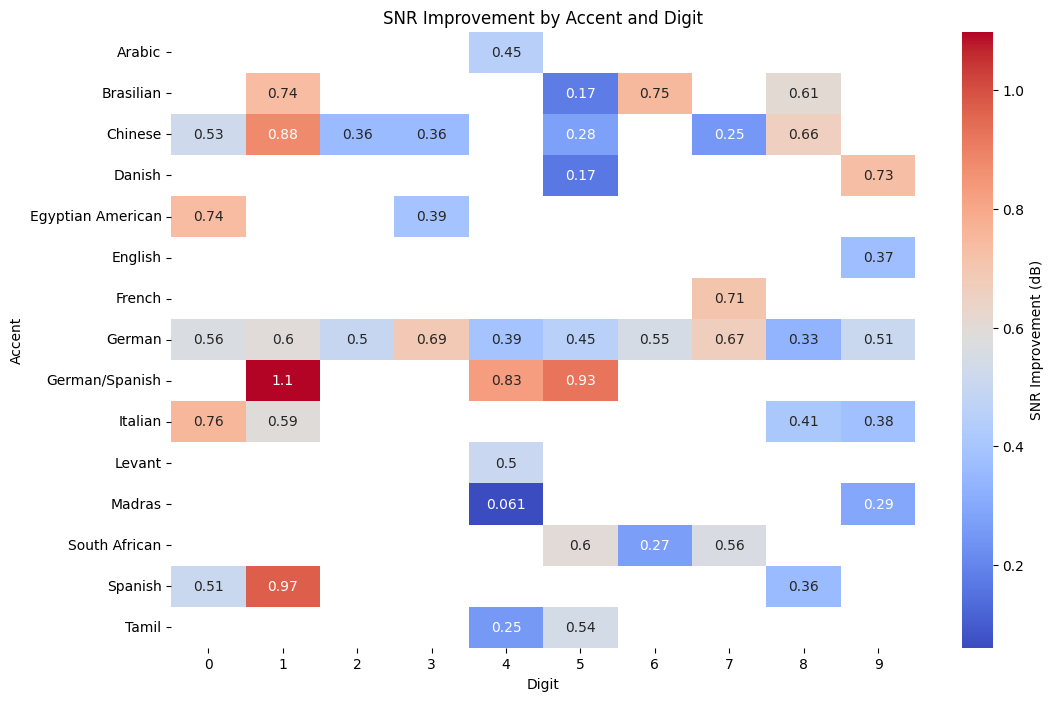

In [54]:
# Create a pivot table for accent-based SNR
snr_by_accent = test_df.groupby([test_df['speaker_index'].map(lambda x: metadata_dict[str(x).zfill(2)]['accent']), 'digit'])['snr'].mean()

# Heatmap of SNR by accent and digit
snr_by_accent = snr_by_accent.unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(snr_by_accent, annot=True, cmap='coolwarm', cbar_kws={'label': 'SNR Improvement (dB)'})
plt.title("SNR Improvement by Accent and Digit")
plt.xlabel("Digit")
plt.ylabel("Accent")
plt.show()

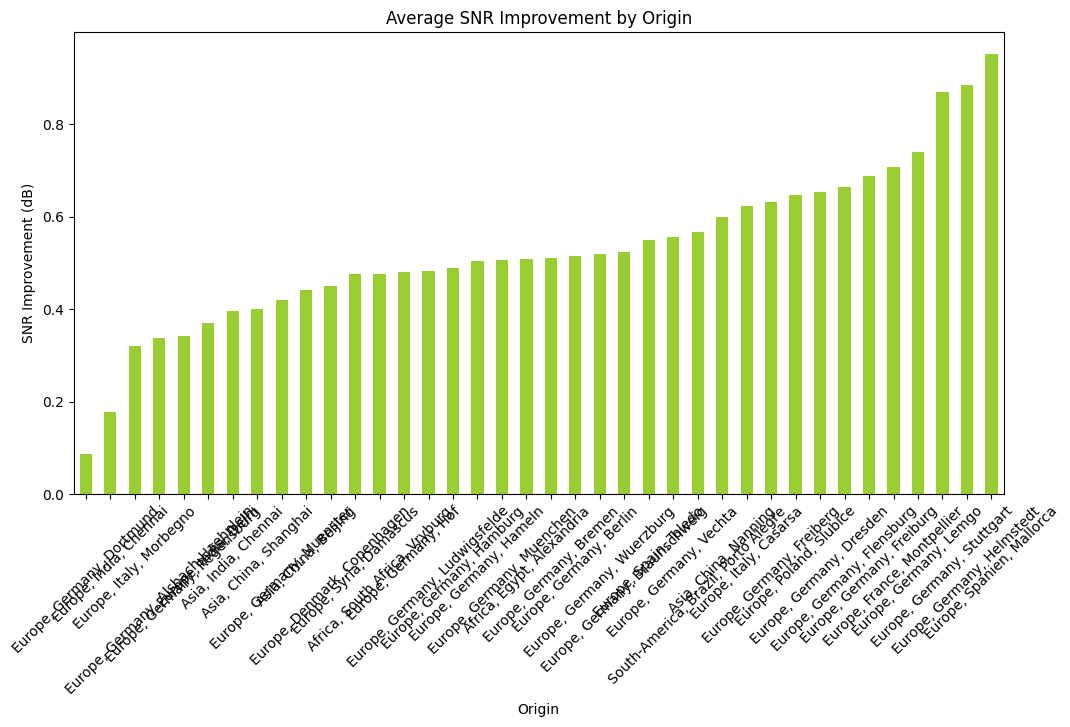

In [55]:
# SNR by origin
snr_by_origin = test_df.groupby(test_df['speaker_index'].map(lambda x: metadata_dict[str(x).zfill(2)]['origin']))['snr'].mean()

# Bar plot for origin
plt.figure(figsize=(12, 6))
snr_by_origin.sort_values().plot(kind="bar", color="yellowgreen")
plt.title("Average SNR Improvement by Origin")
plt.xlabel("Origin")
plt.ylabel("SNR Improvement (dB)")
plt.xticks(rotation=45)
plt.show()